In [1]:
from CovMat import *
import gc
from cl_and_cov import *
from signal_to_noise import *
from fisher_FoM import *

In [2]:
import numpy as np
Omega_m = 0.30
Omega_b = 0.05
h = 0.7
sigma8 = 0.8
n_s= 1
w_0 = -1
w_a = 0
transfer_function = 'bbks'
fsky = 5000/41253

In [3]:
# Input Cosmology object with a given set of parameters
cosmo = ccl.Cosmology(
    Omega_c = Omega_m-Omega_b, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s,
    transfer_function=transfer_function)

In [4]:
arcmin_per_str=(180*60/np.pi)**2
#how many square arcminutes are there in a steradian 
numdenPerStr = arcmin_per_str*10

In [5]:
def distr(z):
    density = (z**2)*np.exp(-(z/(0.8/np.sqrt(2)))**1.5)
    return density

dndz = np.zeros([600,2])
dndz[:, 0] = np.linspace(0.01, 3.01, 600)
dndz[:, 1] = distr(dndz[:, 0])

In [6]:
i=1
while np.sum(dndz[:i, 1]) <= np.sum(dndz[:, 1])/2:
    i+=1

In [7]:
print("the median redshift for all galaxy is", dndz[i, 0])

the median redshift for all galaxy is 0.8063272120200334


In [8]:
ell = np.arange(10, 310)
#the lowest l is set to 10 in the paper, and the highest l is found by figure 1

In [9]:
#binning in l
binl=10**np.linspace(np.log10(15), np.log10(260), 10)

In [10]:
binl

array([ 15.        ,  20.59419518,  28.27472502,  38.81968038,
        53.29733832,  73.17438587, 100.46450567, 137.93237592,
       189.37375145, 260.        ])

In [11]:
#5 bins of equal galaxy number

cov, cl, redshifts, sliced_dndz = getDataArray(n_bins=5, bin_type='n', cosmo=cosmo, dndz=dndz, ell=ell, numdenPerStr = numdenPerStr, fsky=fsky, shape_noise=0.23)
cov_cosmic_var = getCovMat(fsky, 5, cl,  sliced_dndz, numdenPerStr, ell)
cov_shape = cov - cov_cosmic_var

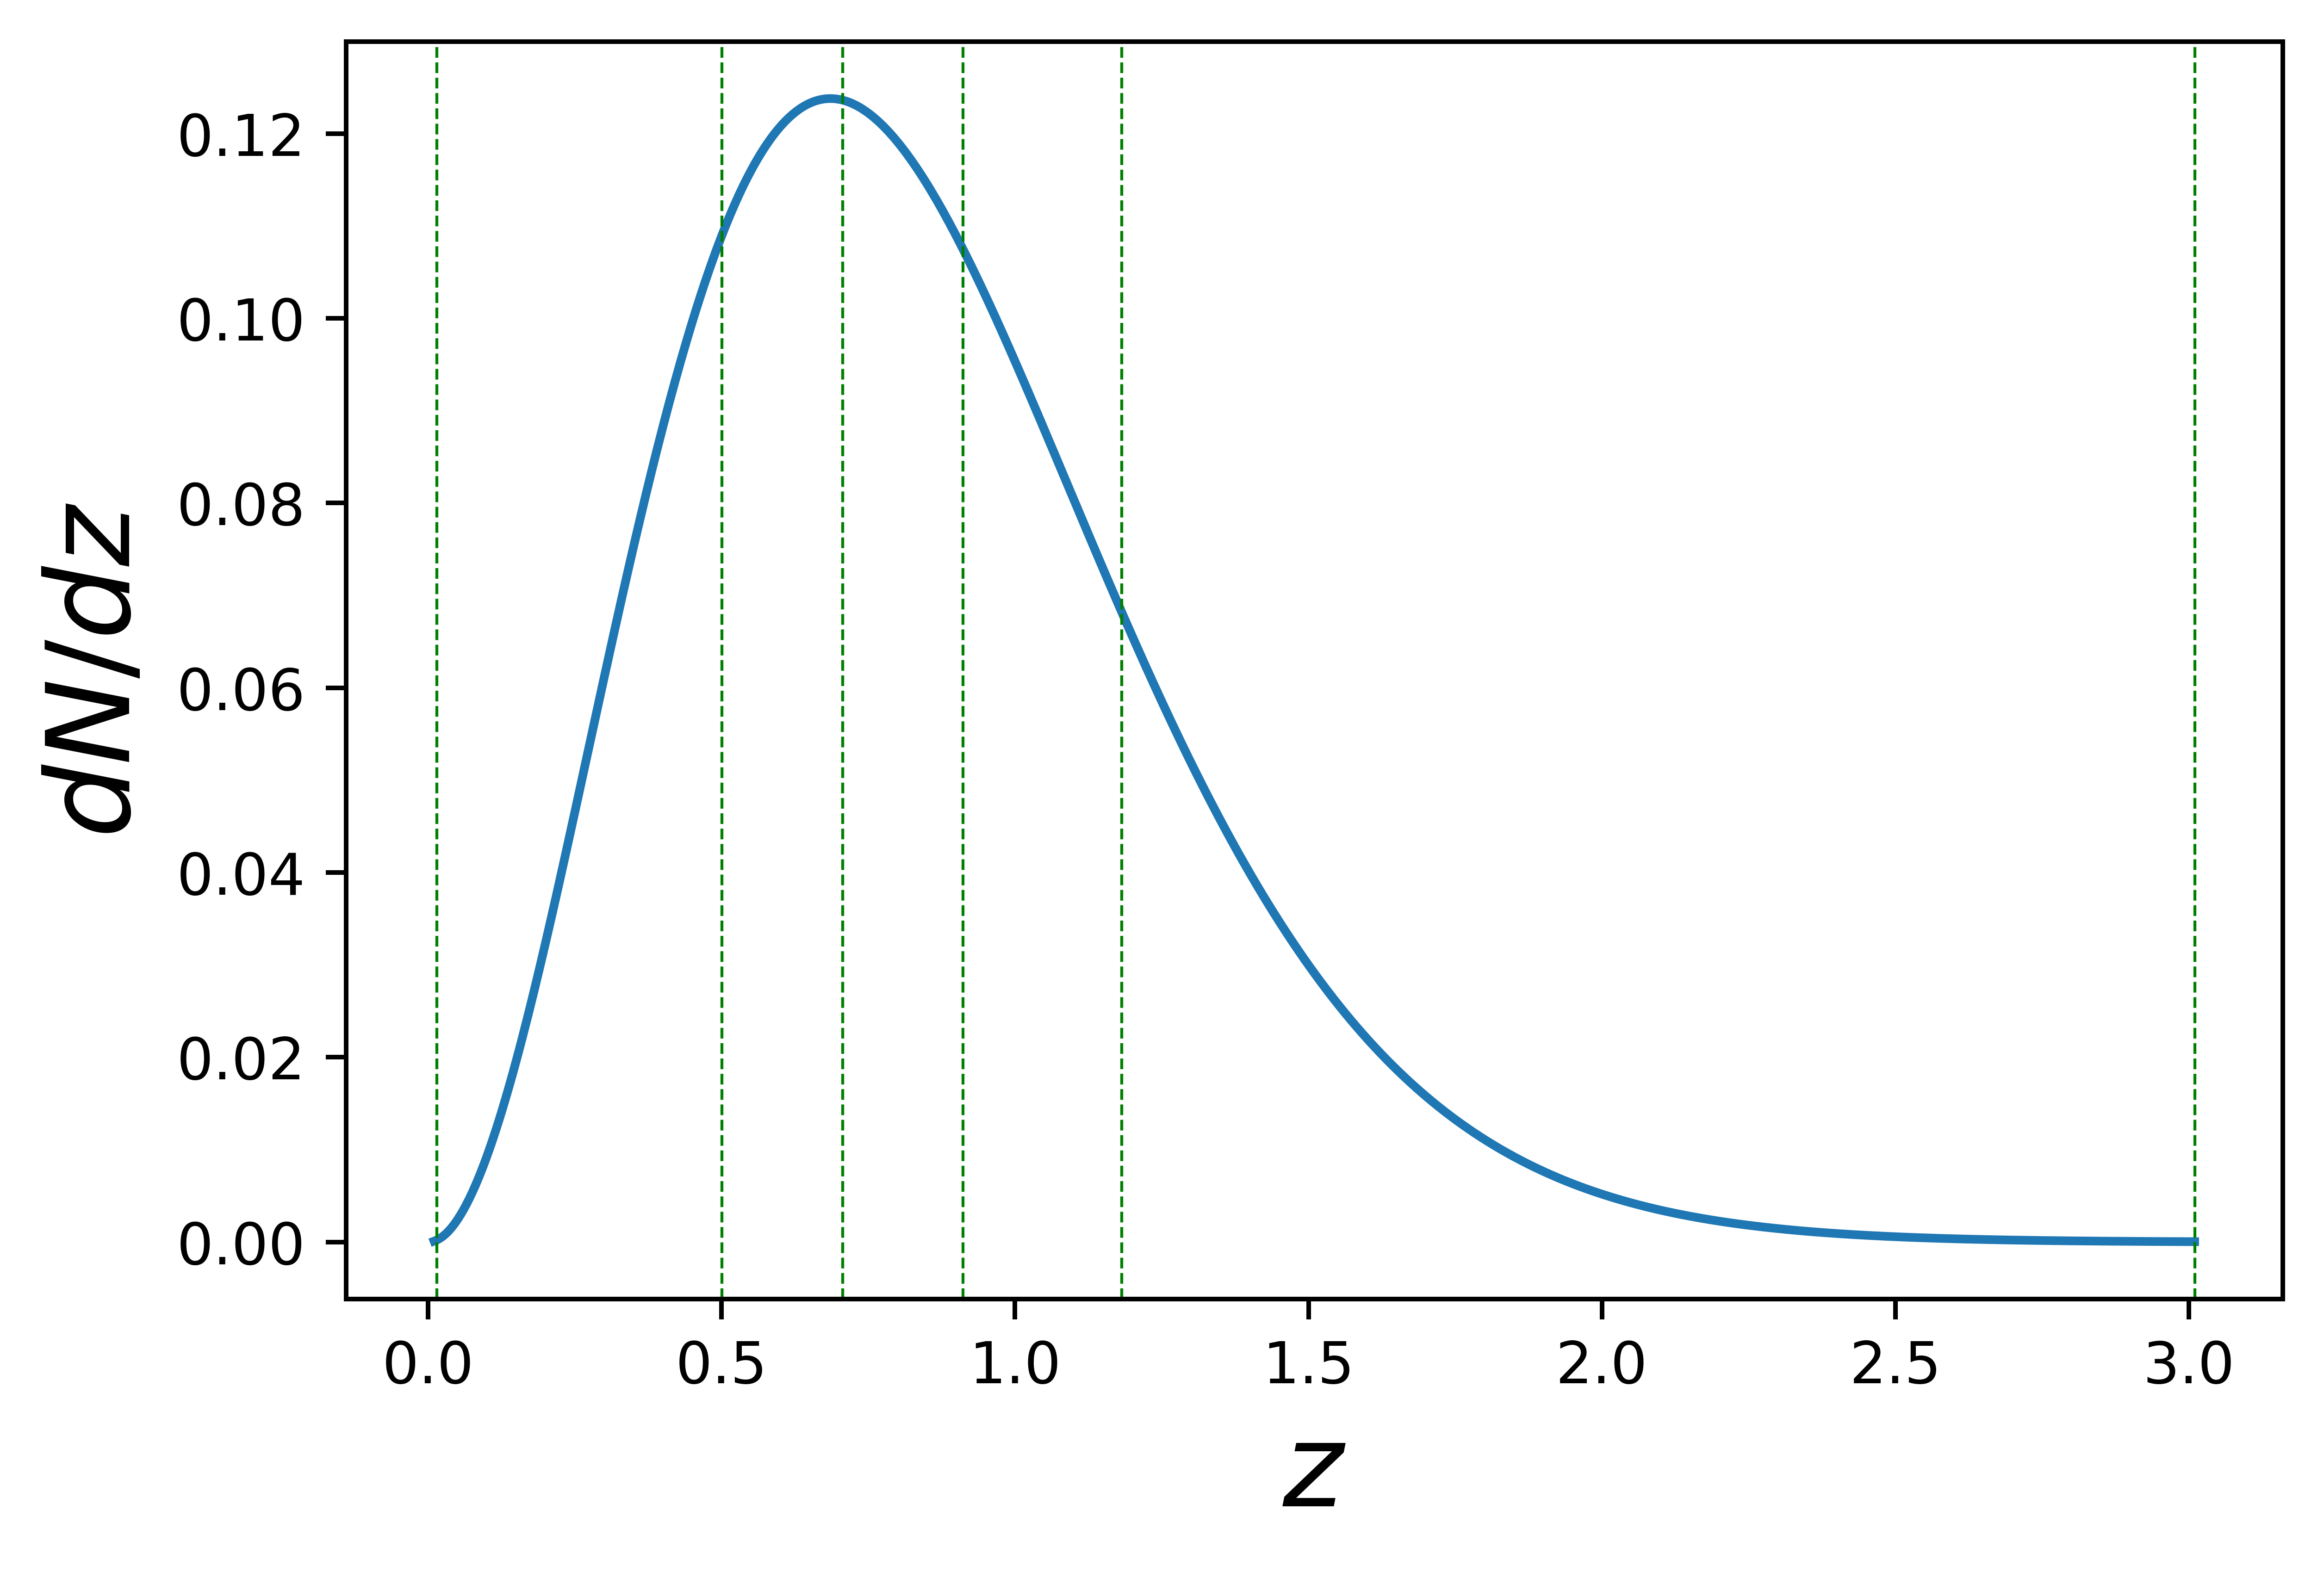

In [12]:
plt.plot(dndz[:,0], dndz[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in redshifts:
    plt.axvline(x, linewidth=0.5, color="g", linestyle="--")
plt.show()

In [13]:
num_den(sliced_dndz, numdenPerStr)/(numdenPerStr/5)

array([0.9819255 , 1.01144538, 1.00391488, 1.00083175, 1.00188248])

In [14]:
stn = SignalToNoise(bins_in_z=5, binl=binl, cl = cl, cov = cov, ell=ell)

In [15]:
stn

56.89915369039471

In [16]:
def SignalToNoise_o(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, in a single tomographic bin"""
    stn_sq = 0
    for i in range(len(cl)):
        stn_sq = stn_sq + cl[i]**2/ cov[i]
    stn = np.sqrt(stn_sq)
    return stn

In [17]:
binned_cl = binnedCl(5, binl, cl, ell)
binned_cov = binnedCov(5, binl, cov, ell)
binned_cov_cosvar = binnedCov(5, binl, cov_cosmic_var, ell)
binned_cov_shape = binnedCov(5, binl, cov_shape, ell)


In [18]:
stn_5bins={}
stn_cosvar={}
stn_shape={}
for i, x in enumerate([0, 5, 9, 12, 14]):
    stn_5bins["{}".format(i+1)] = SignalToNoise_o(binned_cl[x], binned_cov[:, x, x])
    stn_cosvar["{}".format(i+1)] = SignalToNoise_o(binned_cl[x], binned_cov_cosvar[:, x, x])
    stn_shape["{}".format(i+1)] = SignalToNoise_o(binned_cl[x], binned_cov_shape[:, x, x])
        

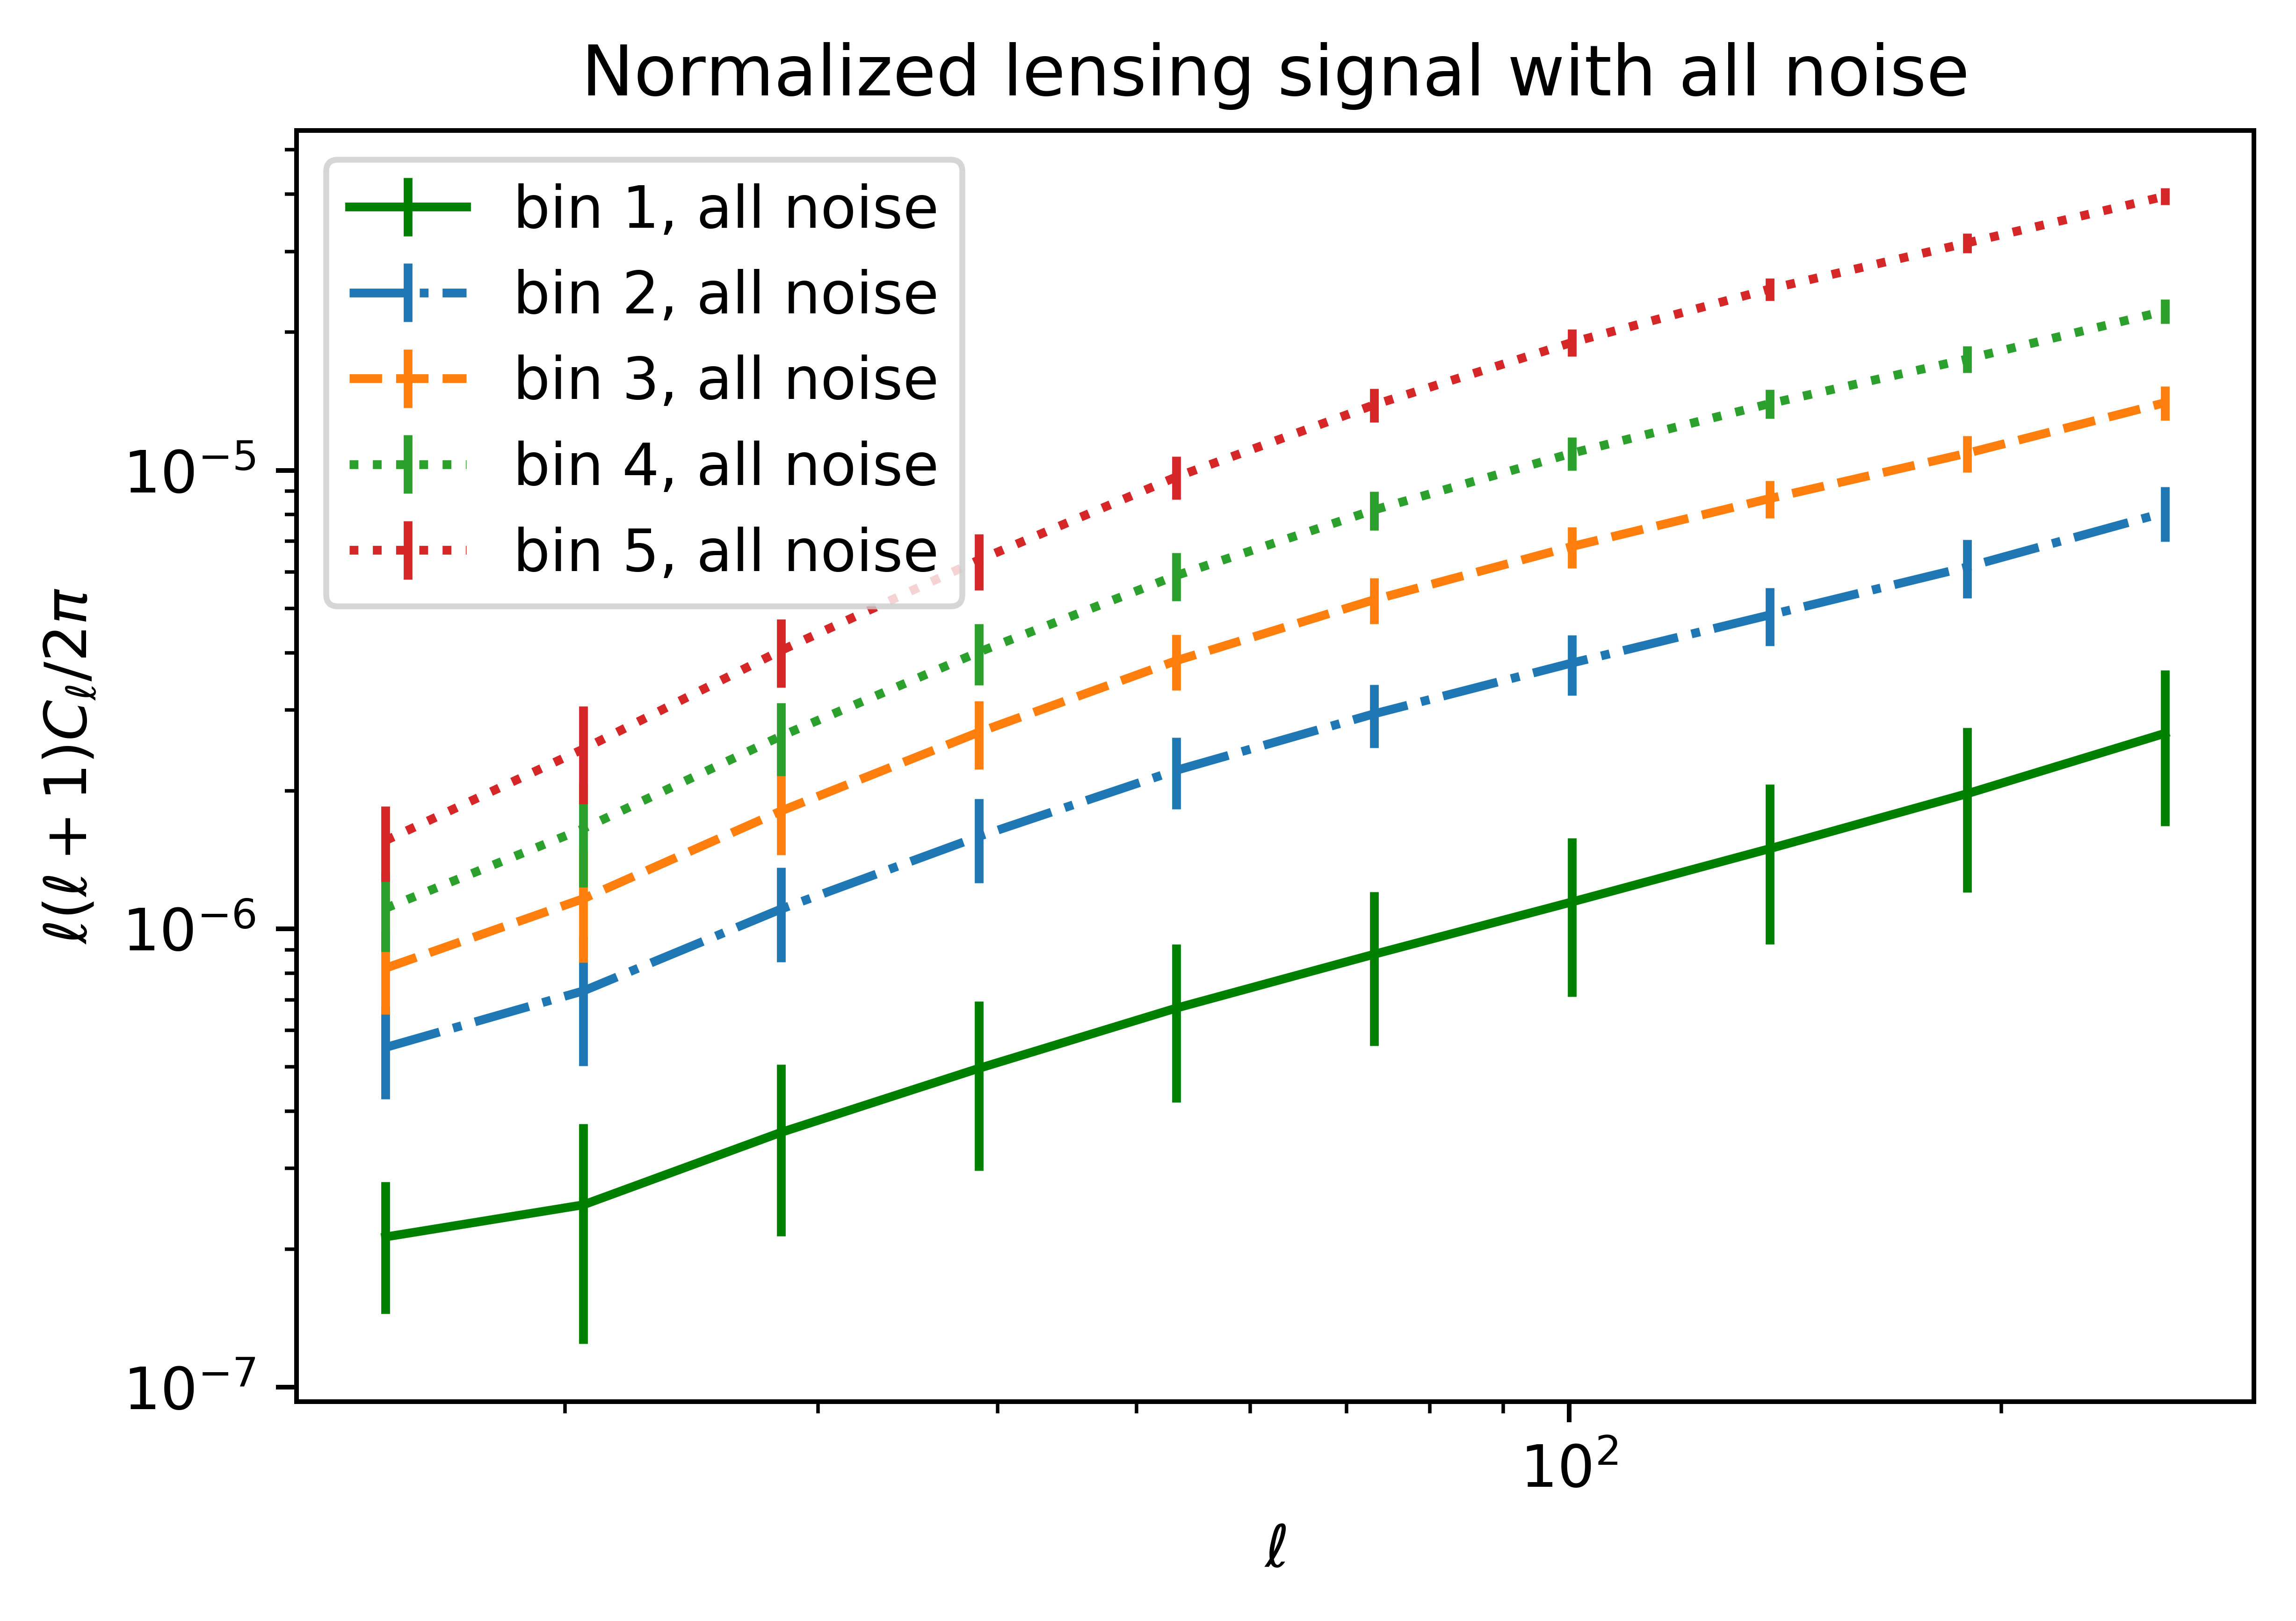

In [19]:
plt.figure()

plt.errorbar(binl, normalizing(binned_cl[0], binl), yerr = normalizing(np.sqrt(binned_cov[:, 0, 0]), binl), color='g', label = "bin 1, all noise")
plt.errorbar(binl, normalizing(binned_cl[5], binl), yerr = normalizing(np.sqrt(binned_cov[:, 5, 5]), binl), ls='-.', label = "bin 2, all noise")
plt.errorbar(binl, normalizing(binned_cl[9], binl), yerr = normalizing(np.sqrt(binned_cov[:, 9, 9]), binl), ls='--', label = "bin 3, all noise")
plt.errorbar(binl, normalizing(binned_cl[12], binl), yerr = normalizing(np.sqrt(binned_cov[:, 12, 12]), binl), ls=':', label = "bin 4, all noise")
plt.errorbar(binl, normalizing(binned_cl[14], binl), yerr = normalizing(np.sqrt(binned_cov[:, 14, 14]), binl), ls='dotted', label = "bin 5, all noise")


plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal with all noise")
plt.show() 

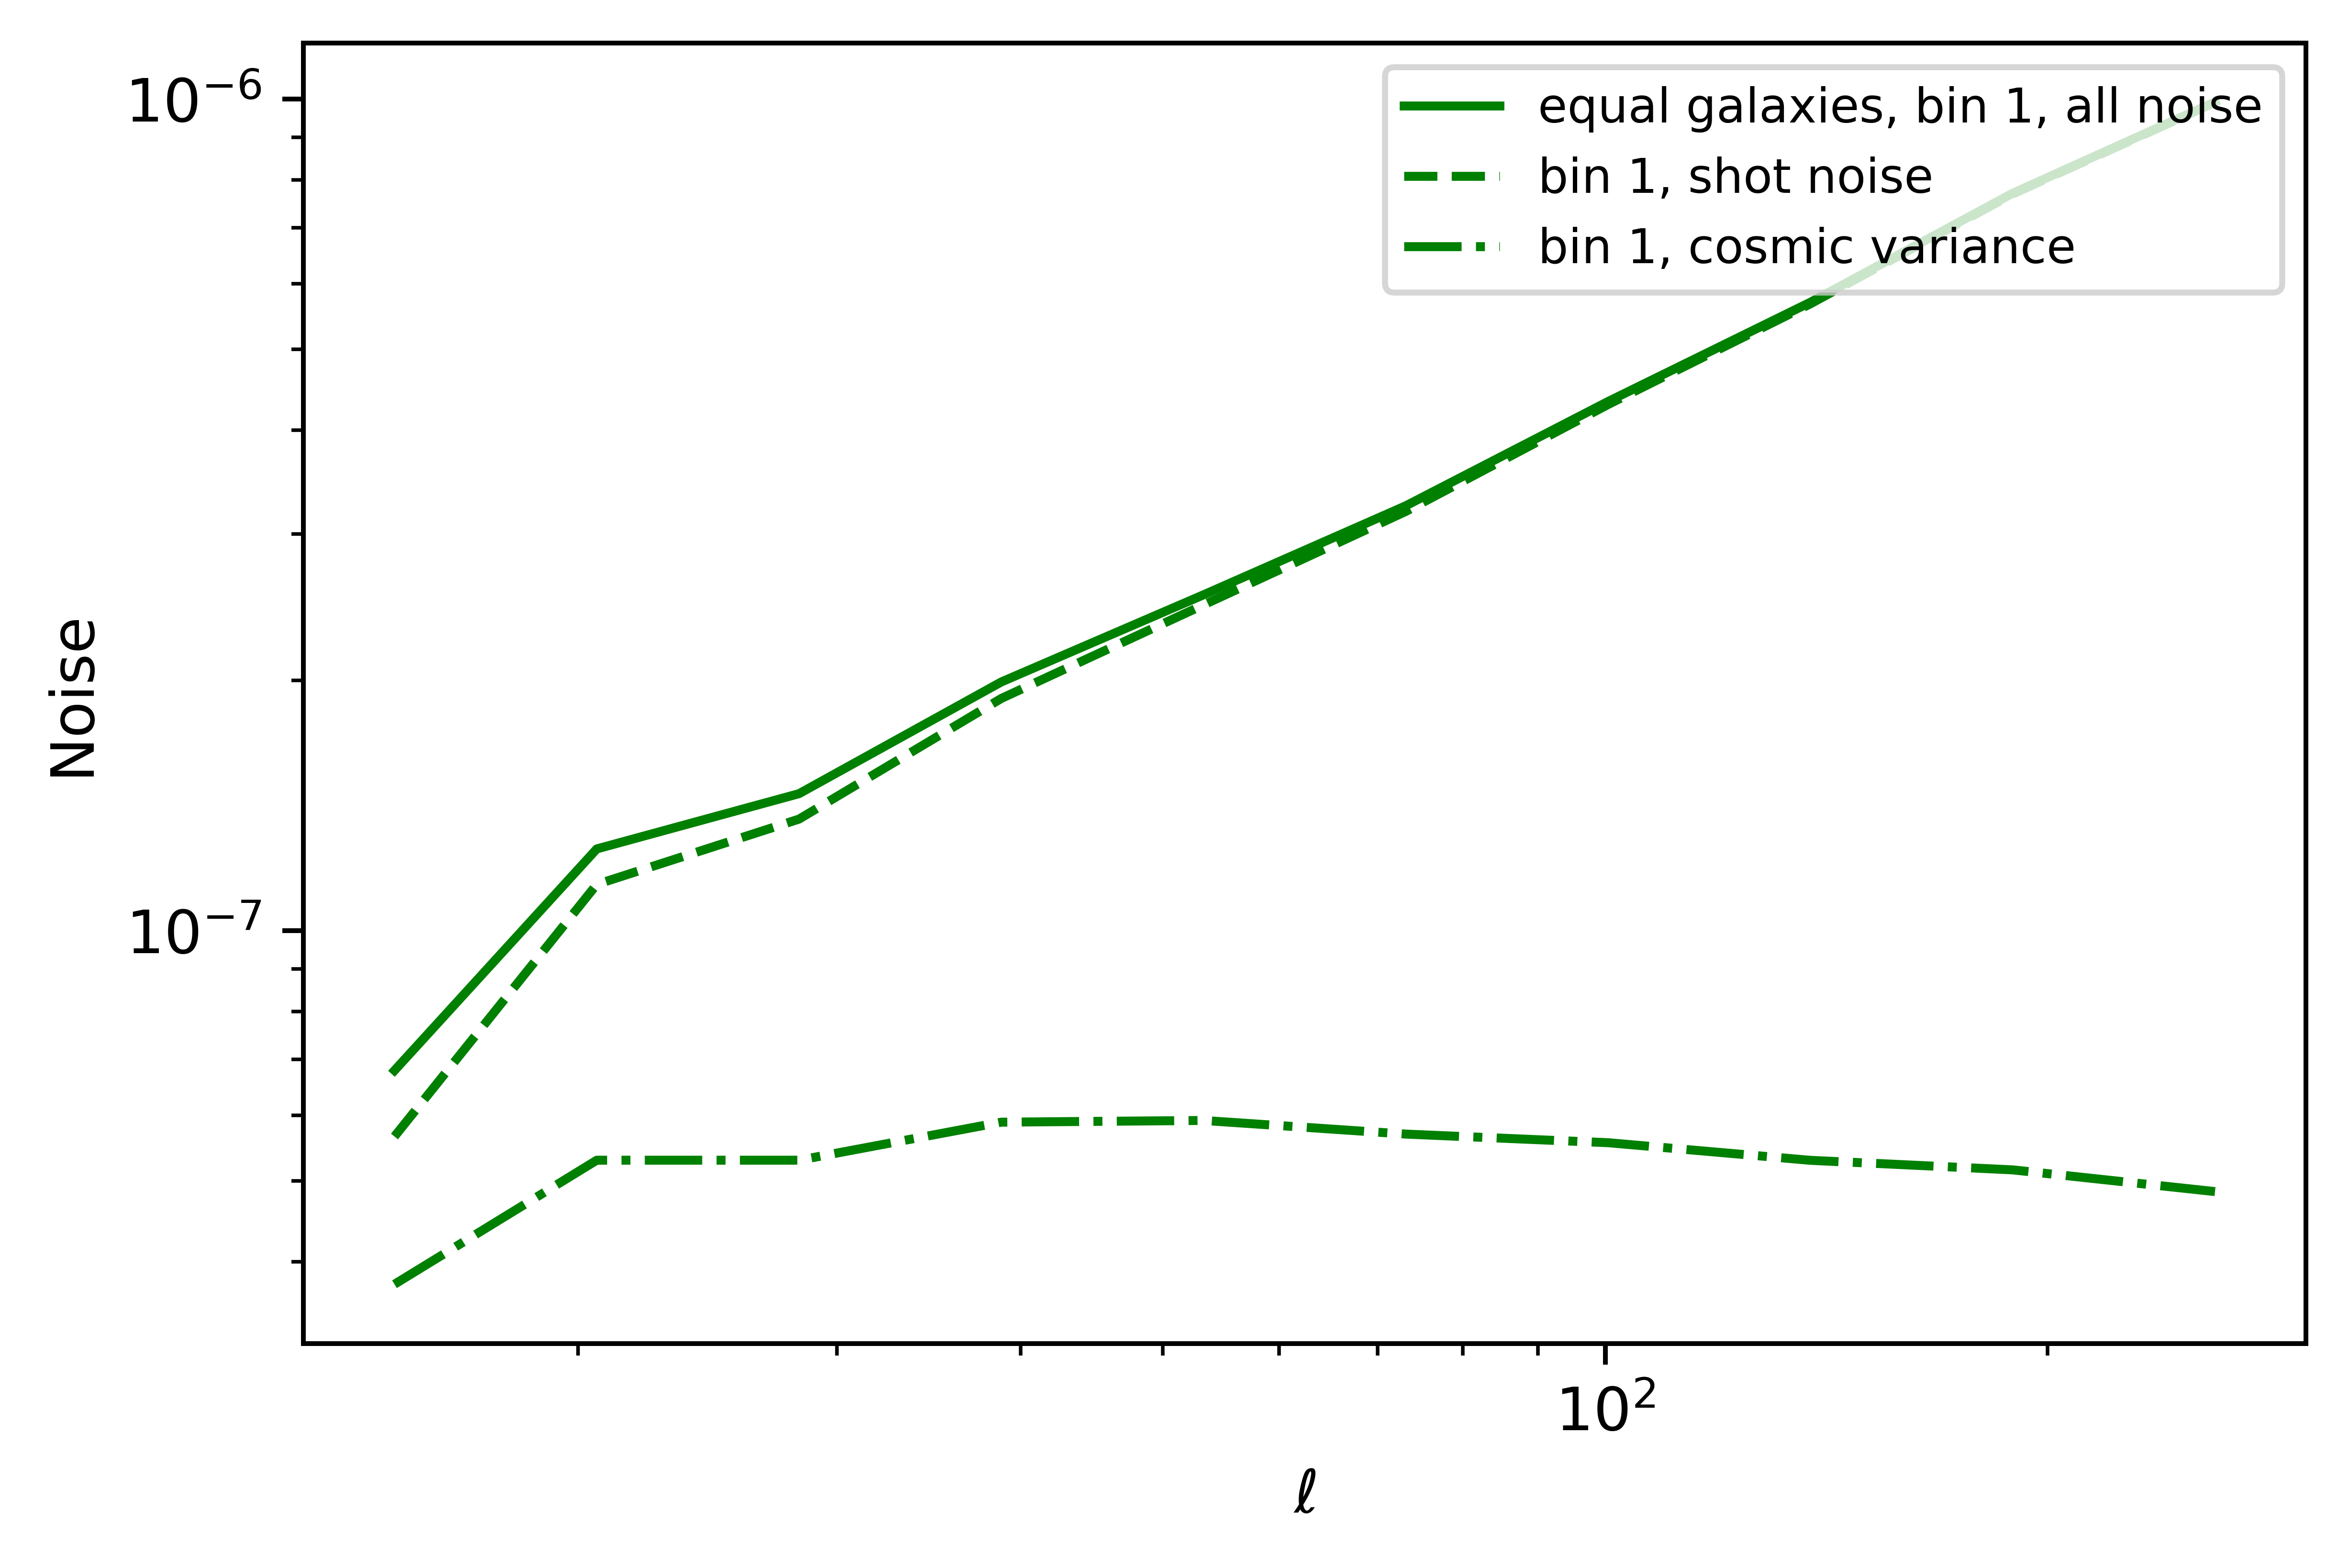

In [20]:
plt.figure()

plt.plot(binl, normalizing(np.sqrt(binned_cov[:, 0, 0]), binl), color='g', label = "equal galaxies, bin 1, all noise")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 0, 0]), binl), color='g', ls="--", label = "bin 1, shot noise")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 0, 0]), binl), color='g', ls="-.", label = "bin 1, cosmic variance")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel('Noise')
plt.legend(loc="upper right", fontsize=8)
plt.show() 

At all scale, the noise in bin 1 is dominated by shot noise

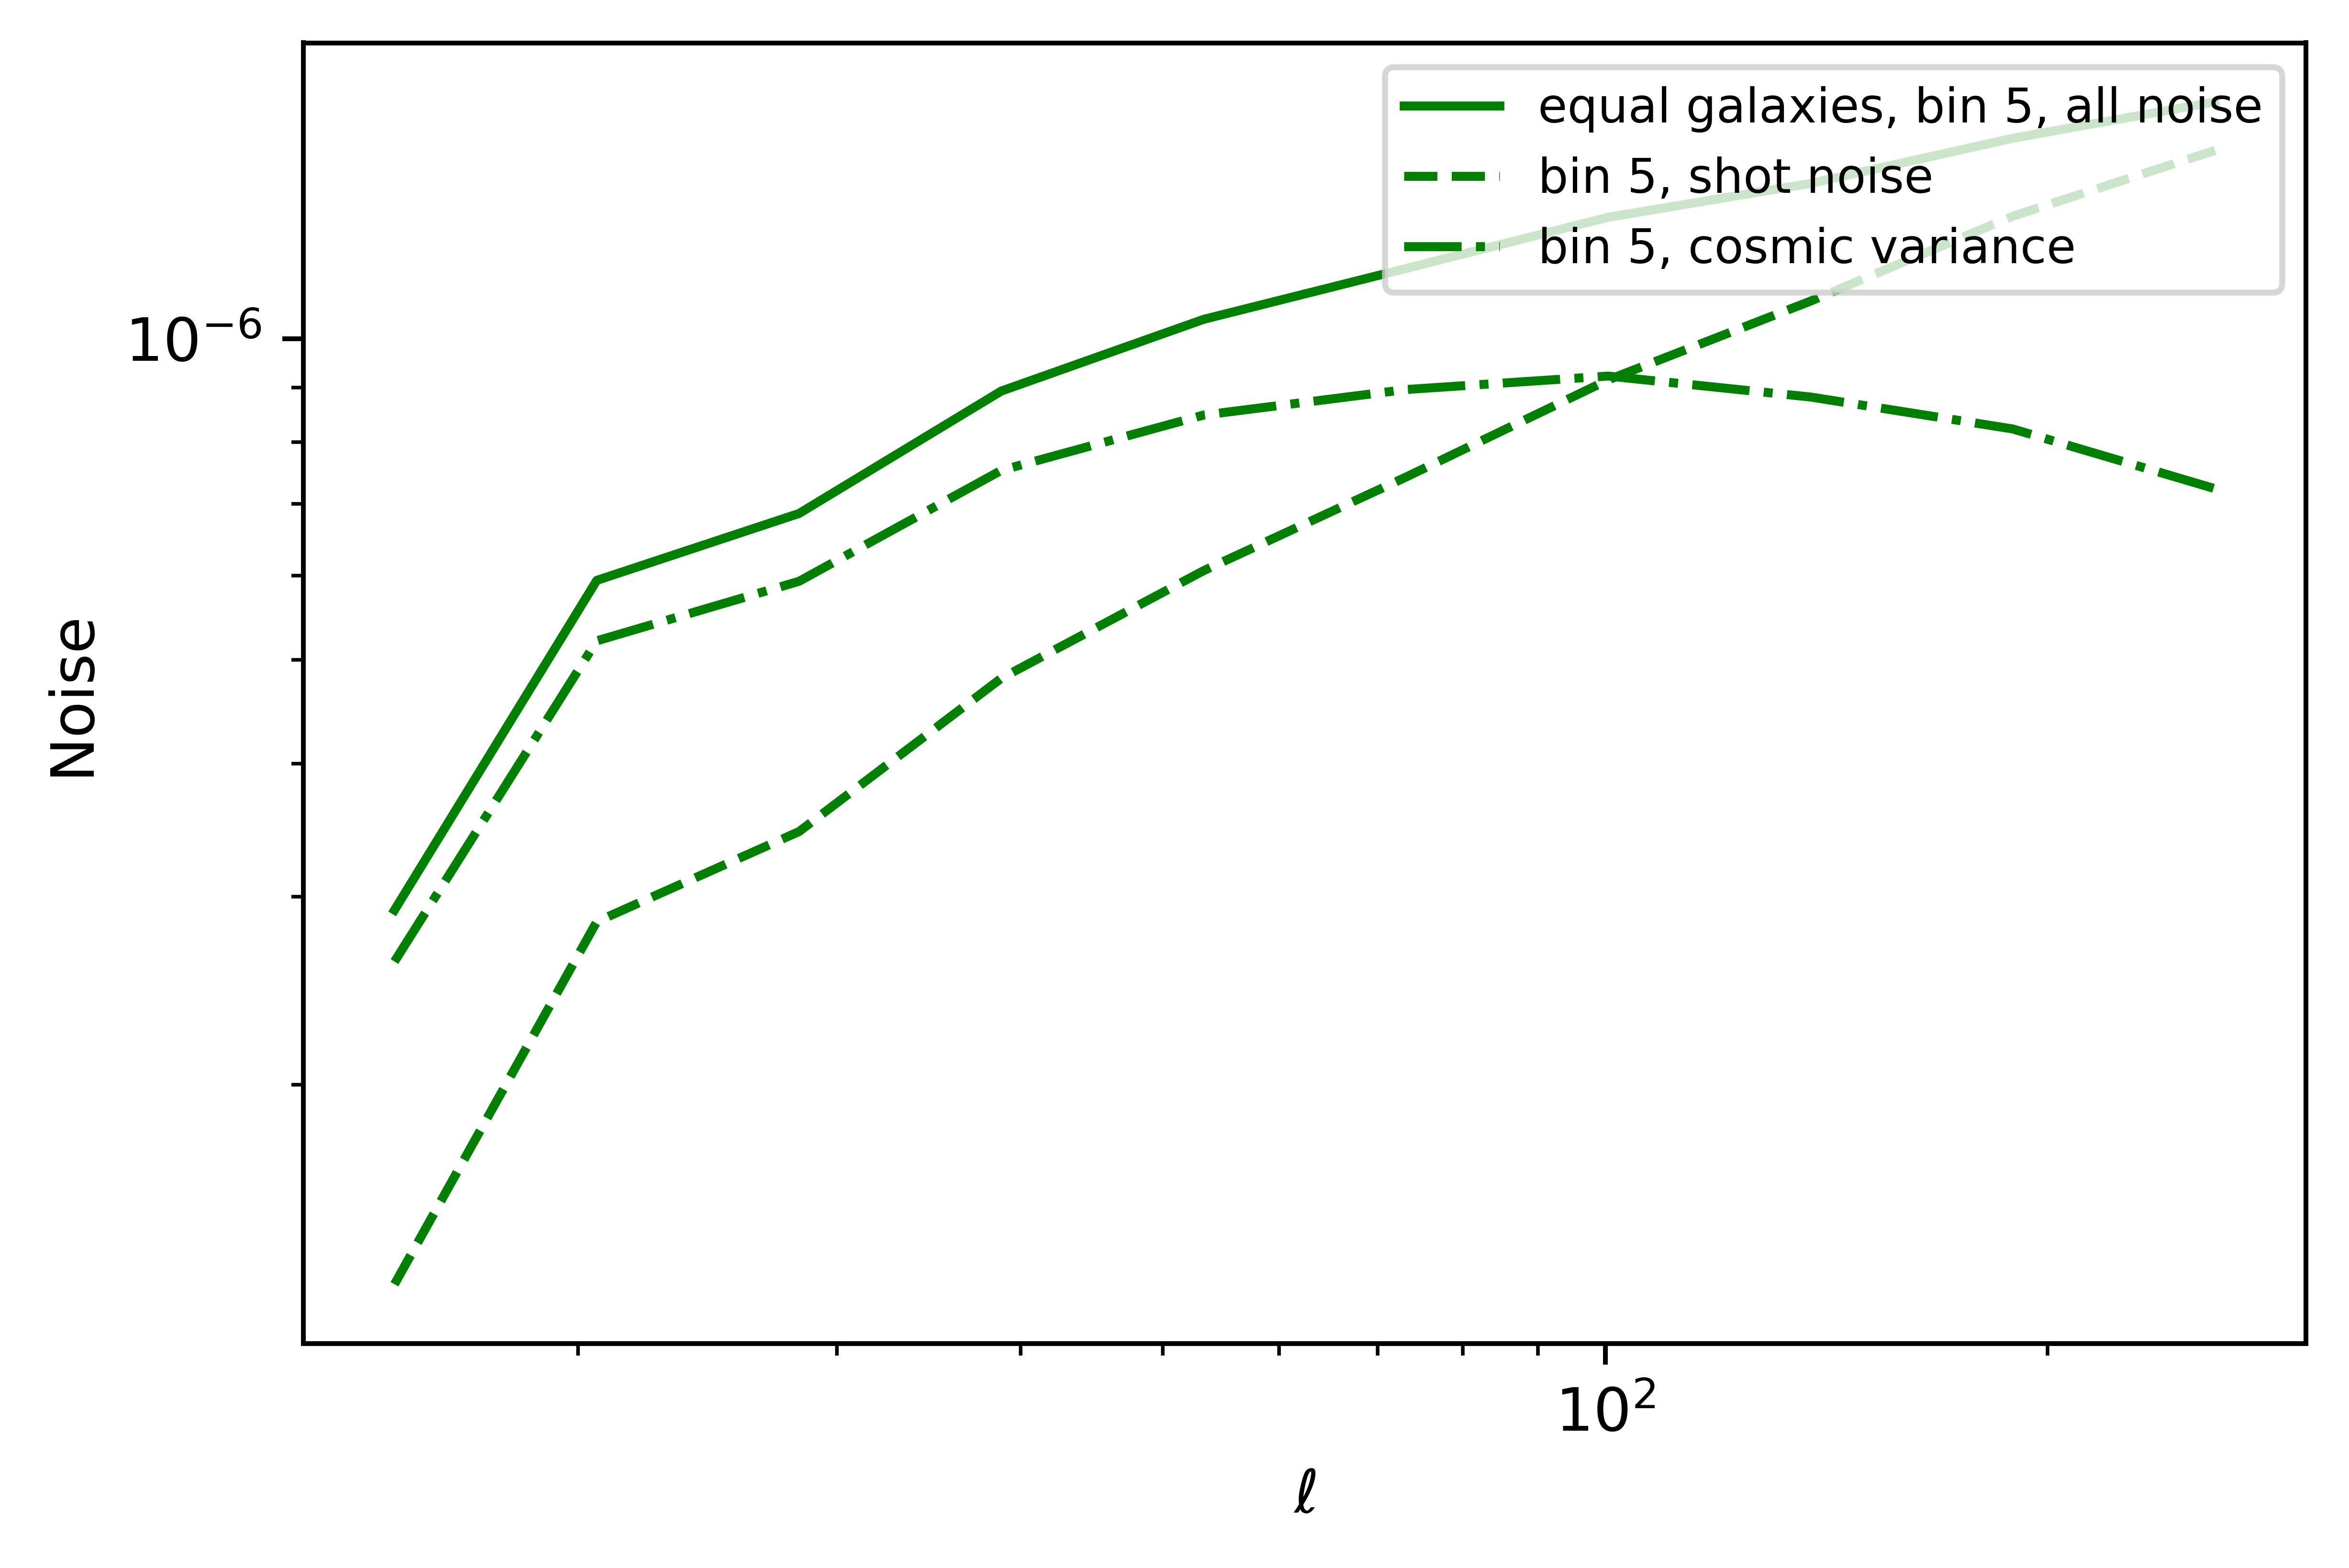

In [21]:
plt.figure()

plt.plot(binl, normalizing(np.sqrt(binned_cov[:, 14, 14]), binl), color='g', label = "equal galaxies, bin 5, all noise")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 14, 14]), binl), color='g', ls="--", label = "bin 5, shot noise")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 14, 14]), binl), color='g', ls="-.", label = "bin 5, cosmic variance")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel('Noise')
plt.legend(loc="upper right", fontsize=8)
plt.show() 

in bin 5, cosmic variance dominate the large scale, and shot noise become significant at small scale

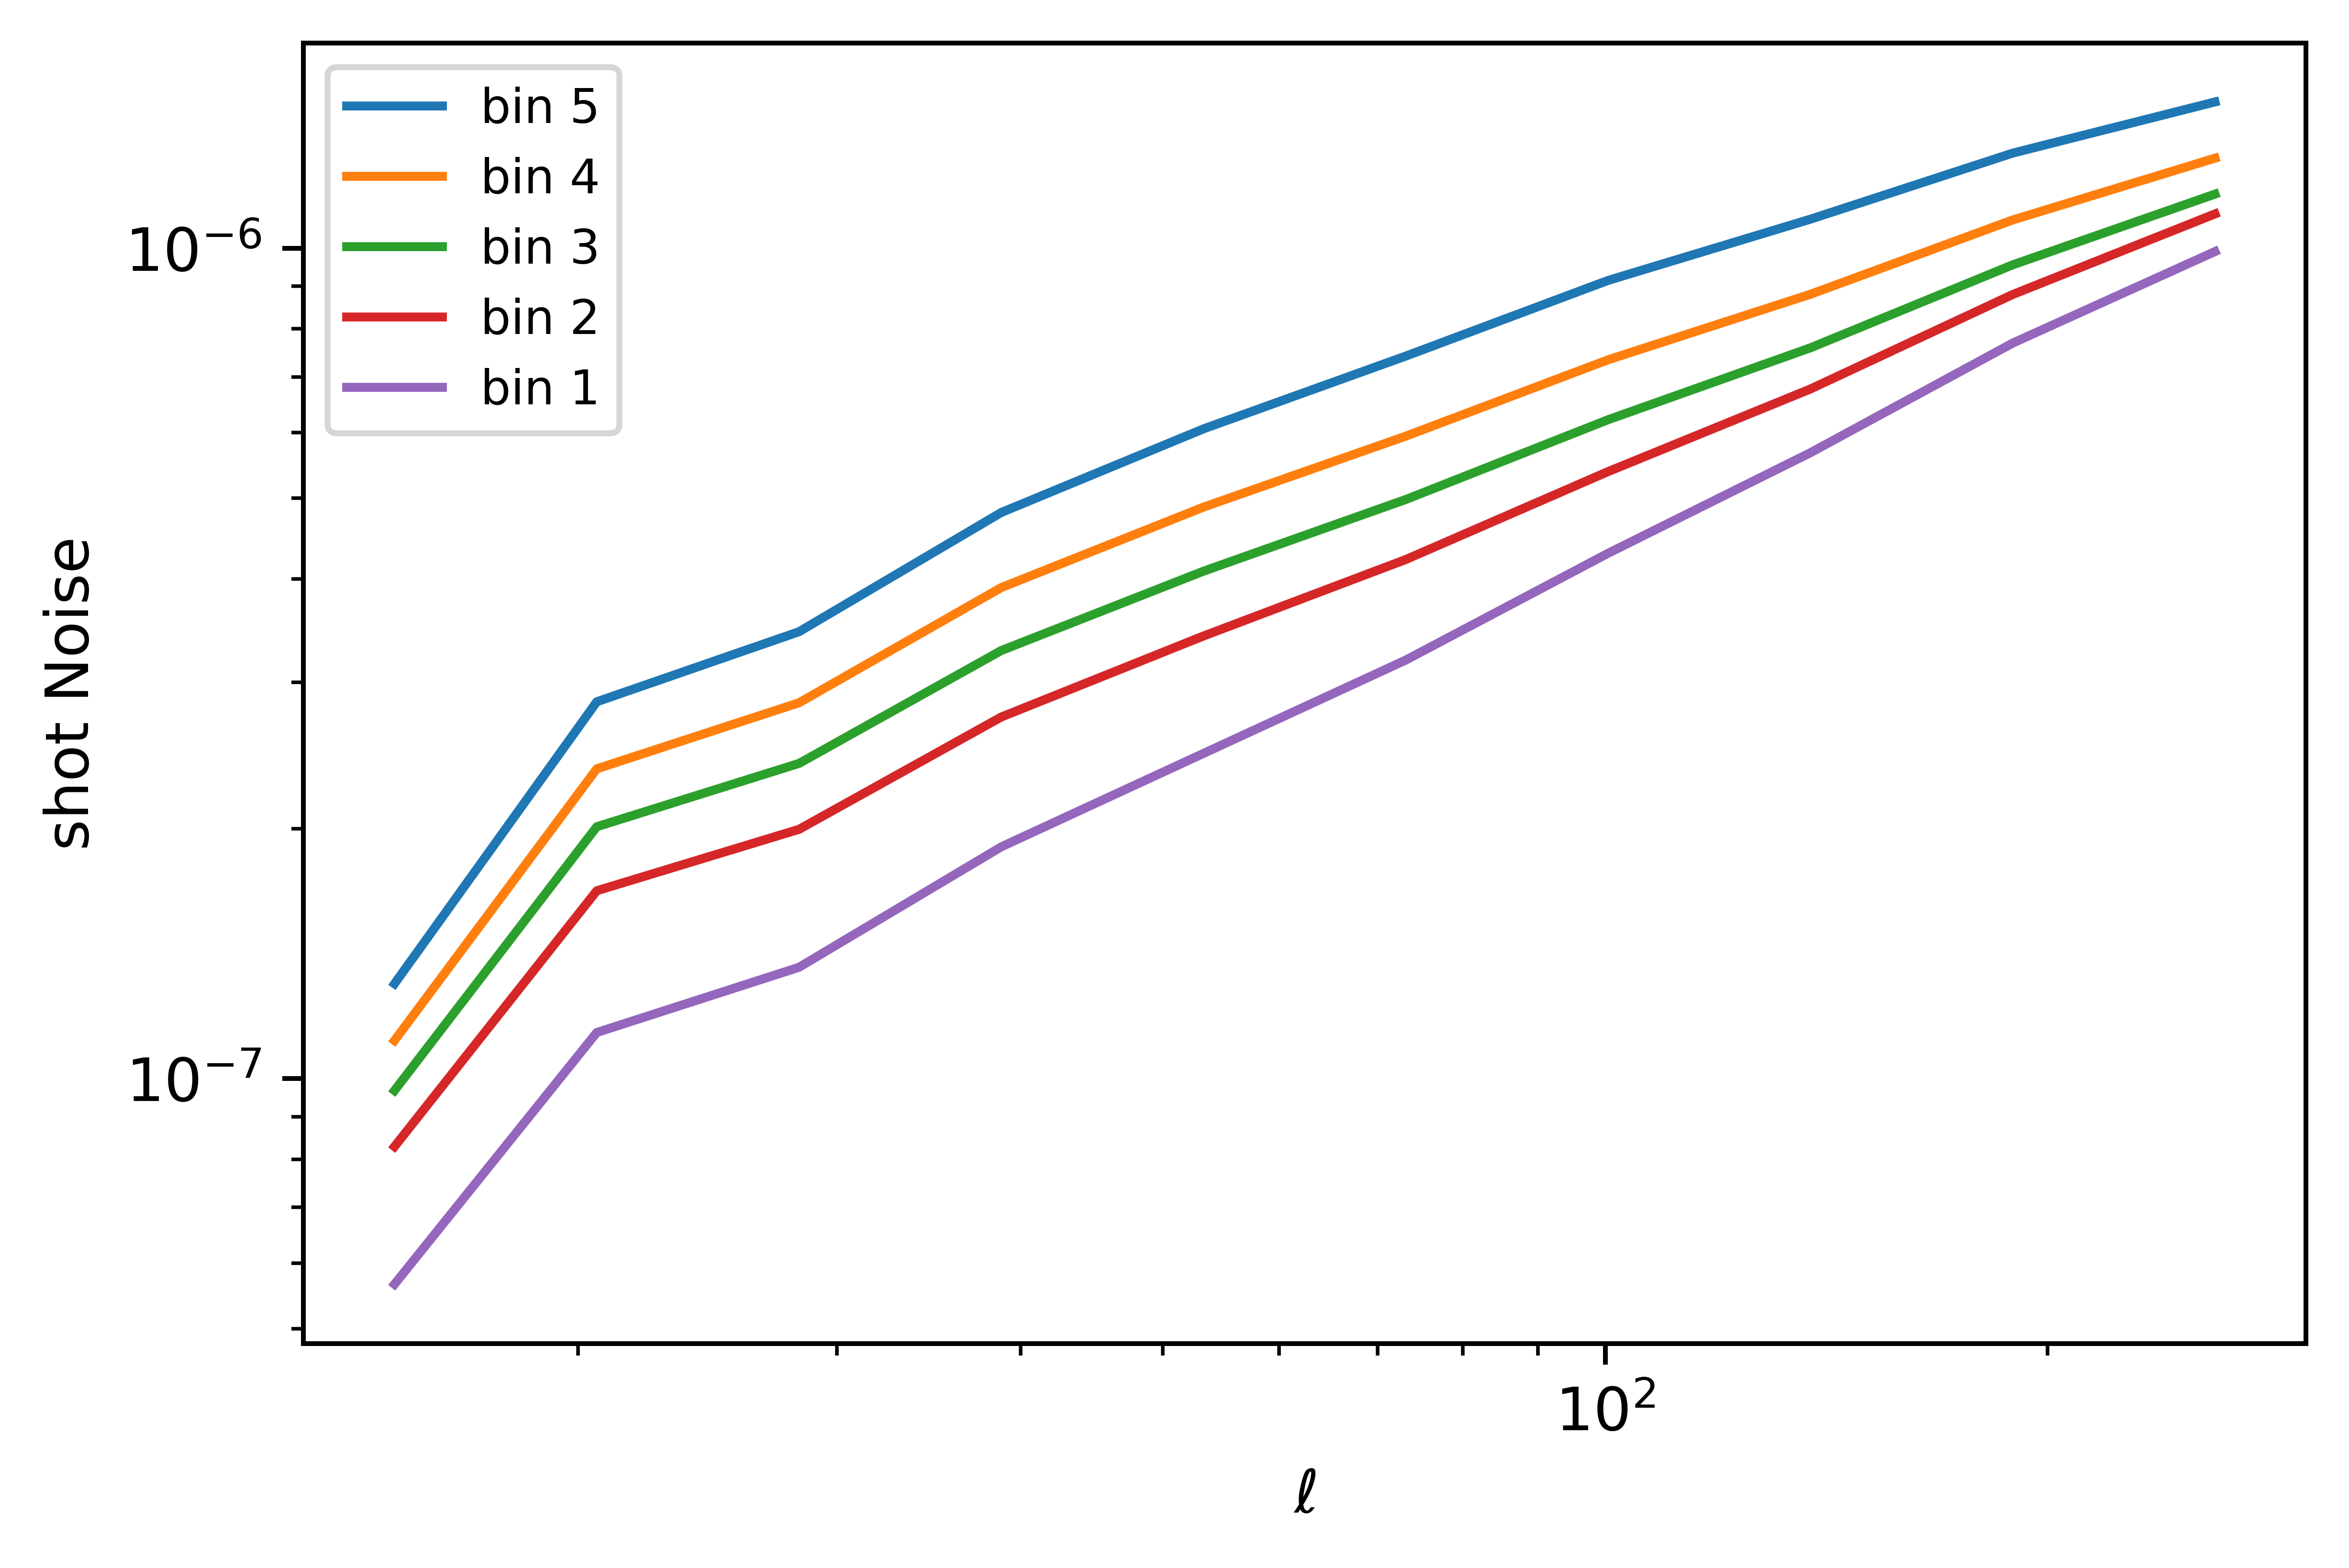

In [22]:
plt.figure()

plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 14, 14]), binl), label = "bin 5")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 12, 12]), binl), label = "bin 4")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 9, 9]), binl), label = "bin 3")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 5, 5]), binl), label = "bin 2")
plt.plot(binl, normalizing(np.sqrt(binned_cov_shape[:, 0, 0]), binl), label = "bin 1")


plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel('shot Noise')
plt.legend(loc="upper left", fontsize=8)
plt.show() 

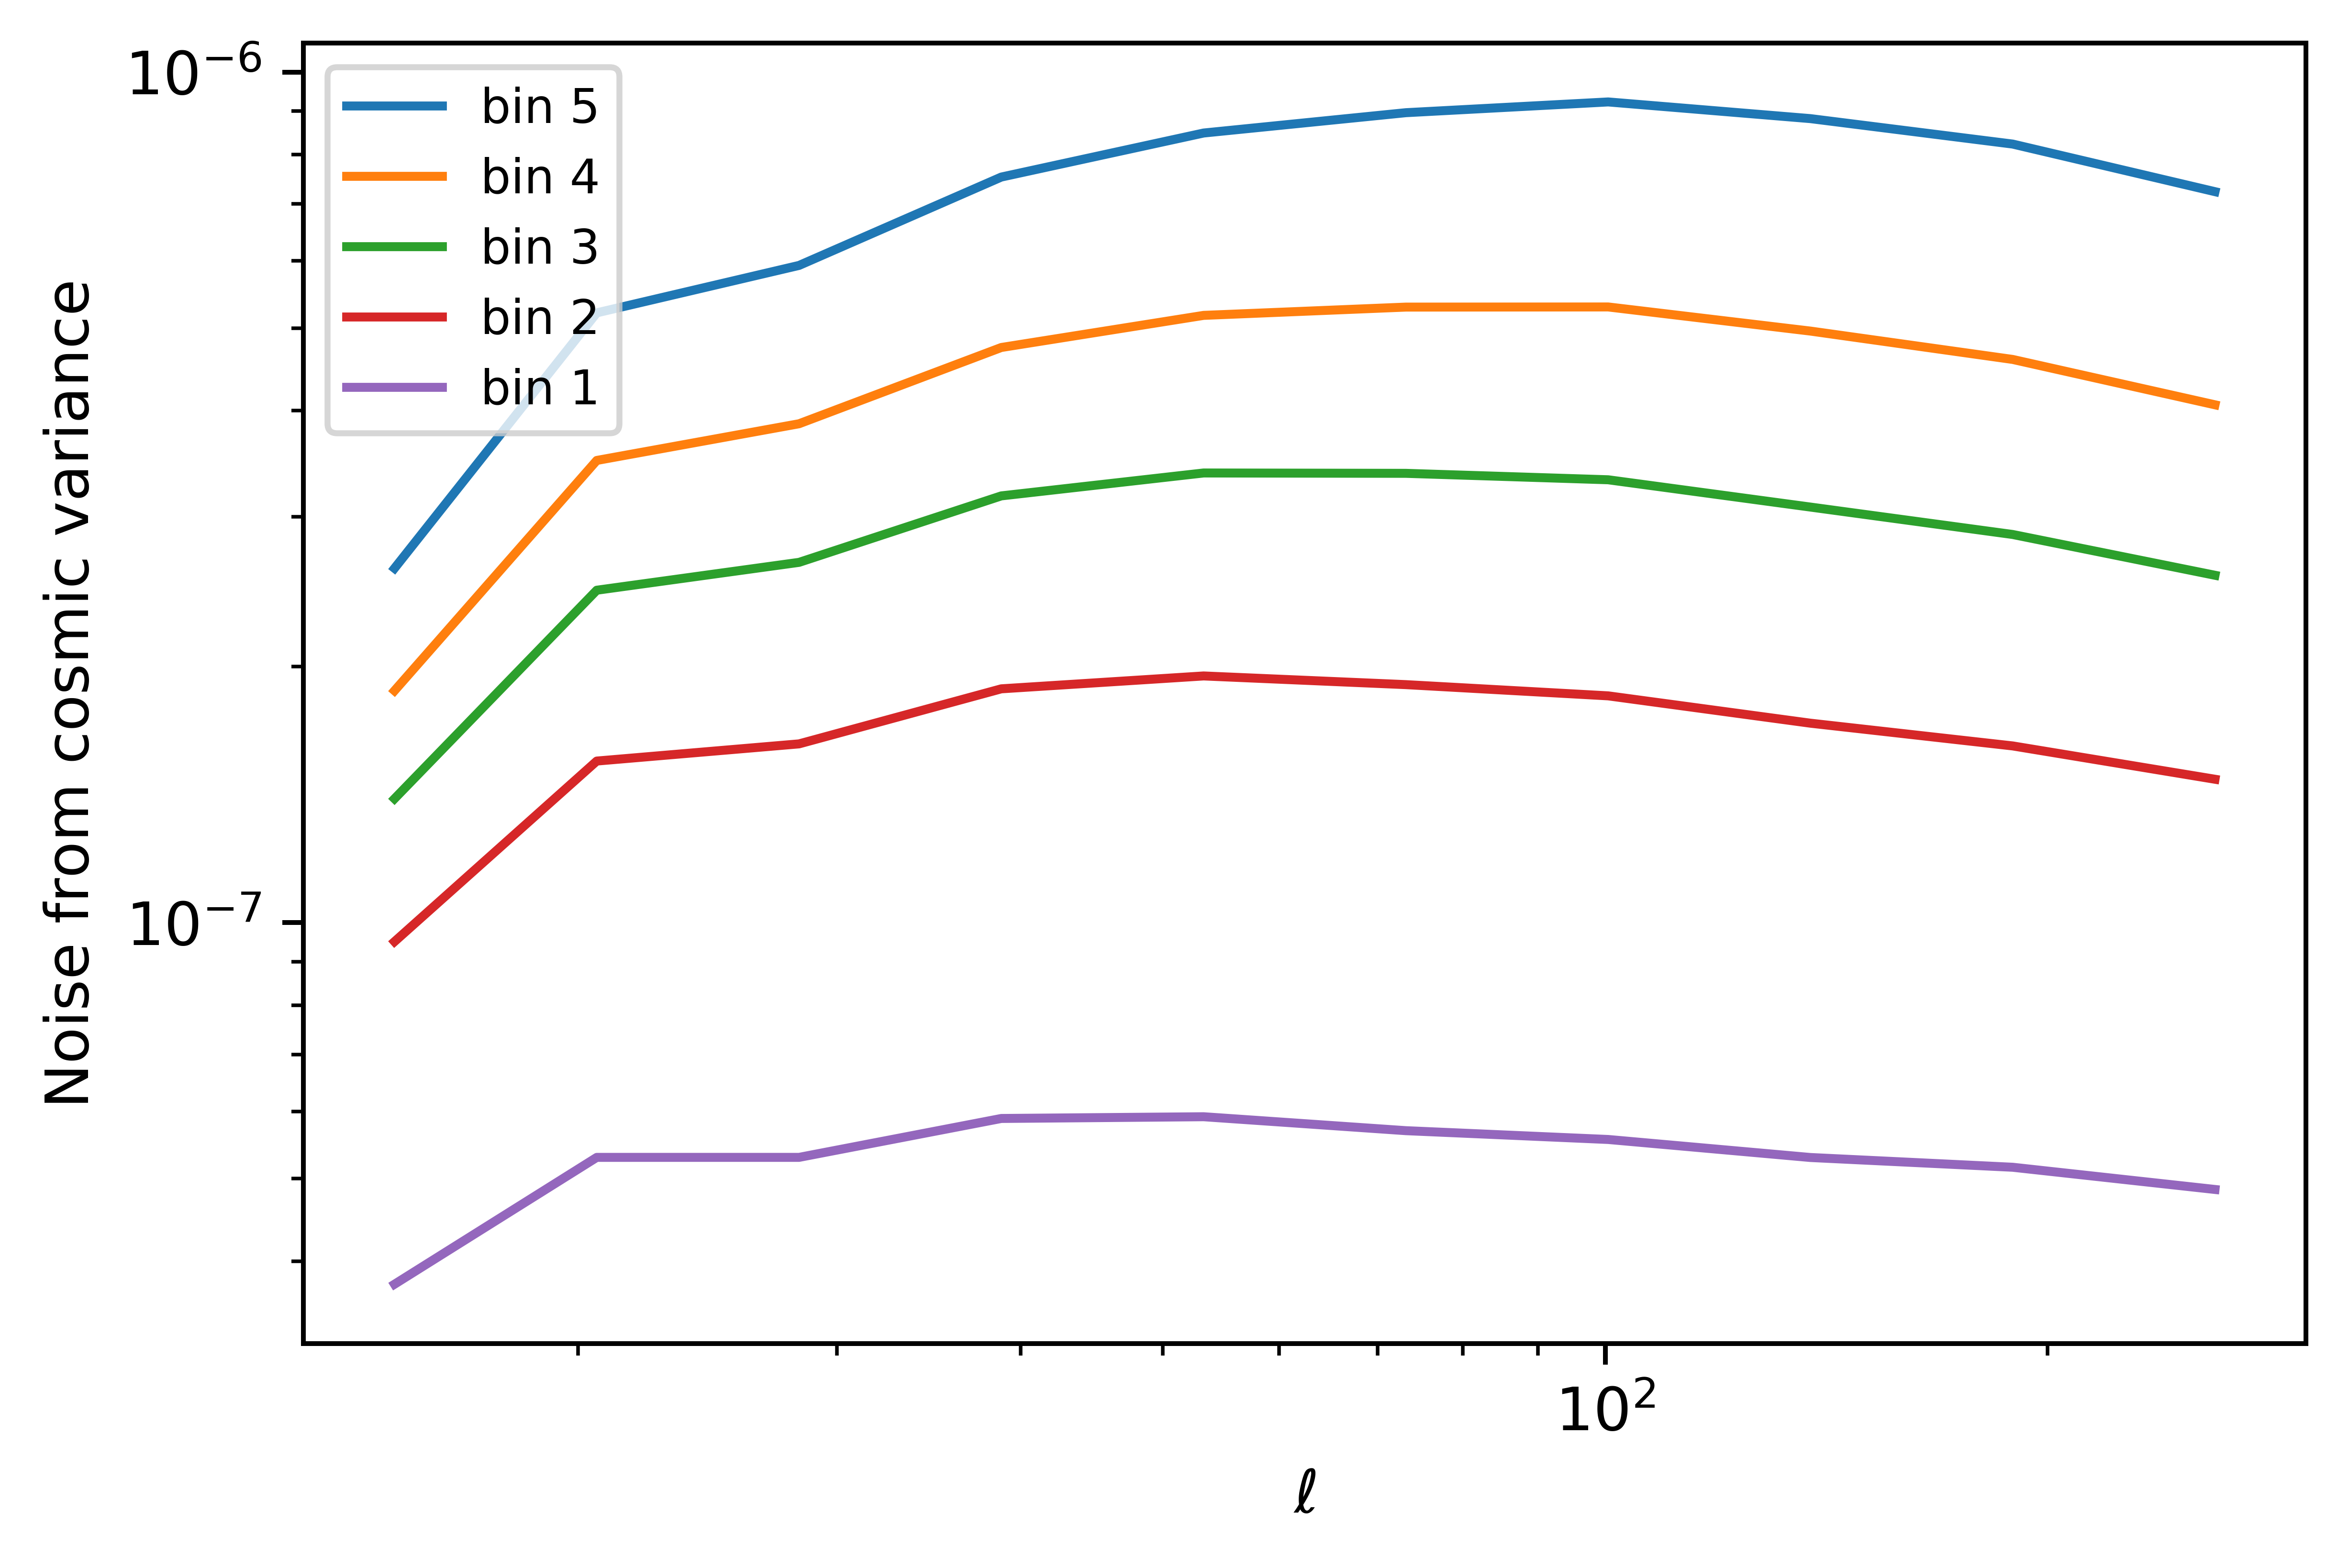

In [23]:
plt.figure()

plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 14, 14]), binl), label = "bin 5")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 12, 12]), binl), label = "bin 4")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 9, 9]), binl), label = "bin 3")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 5, 5]), binl), label = "bin 2")
plt.plot(binl, normalizing(np.sqrt(binned_cov_cosvar[:, 0, 0]), binl), label = "bin 1")


plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$')
plt.ylabel('Noise from cosmic variance')
plt.legend(loc="upper left", fontsize=8)
plt.show() 

In [24]:
fisher = fisher_matrix(covariance=cov, dndz_sliced=sliced_dndz, ell=ell)

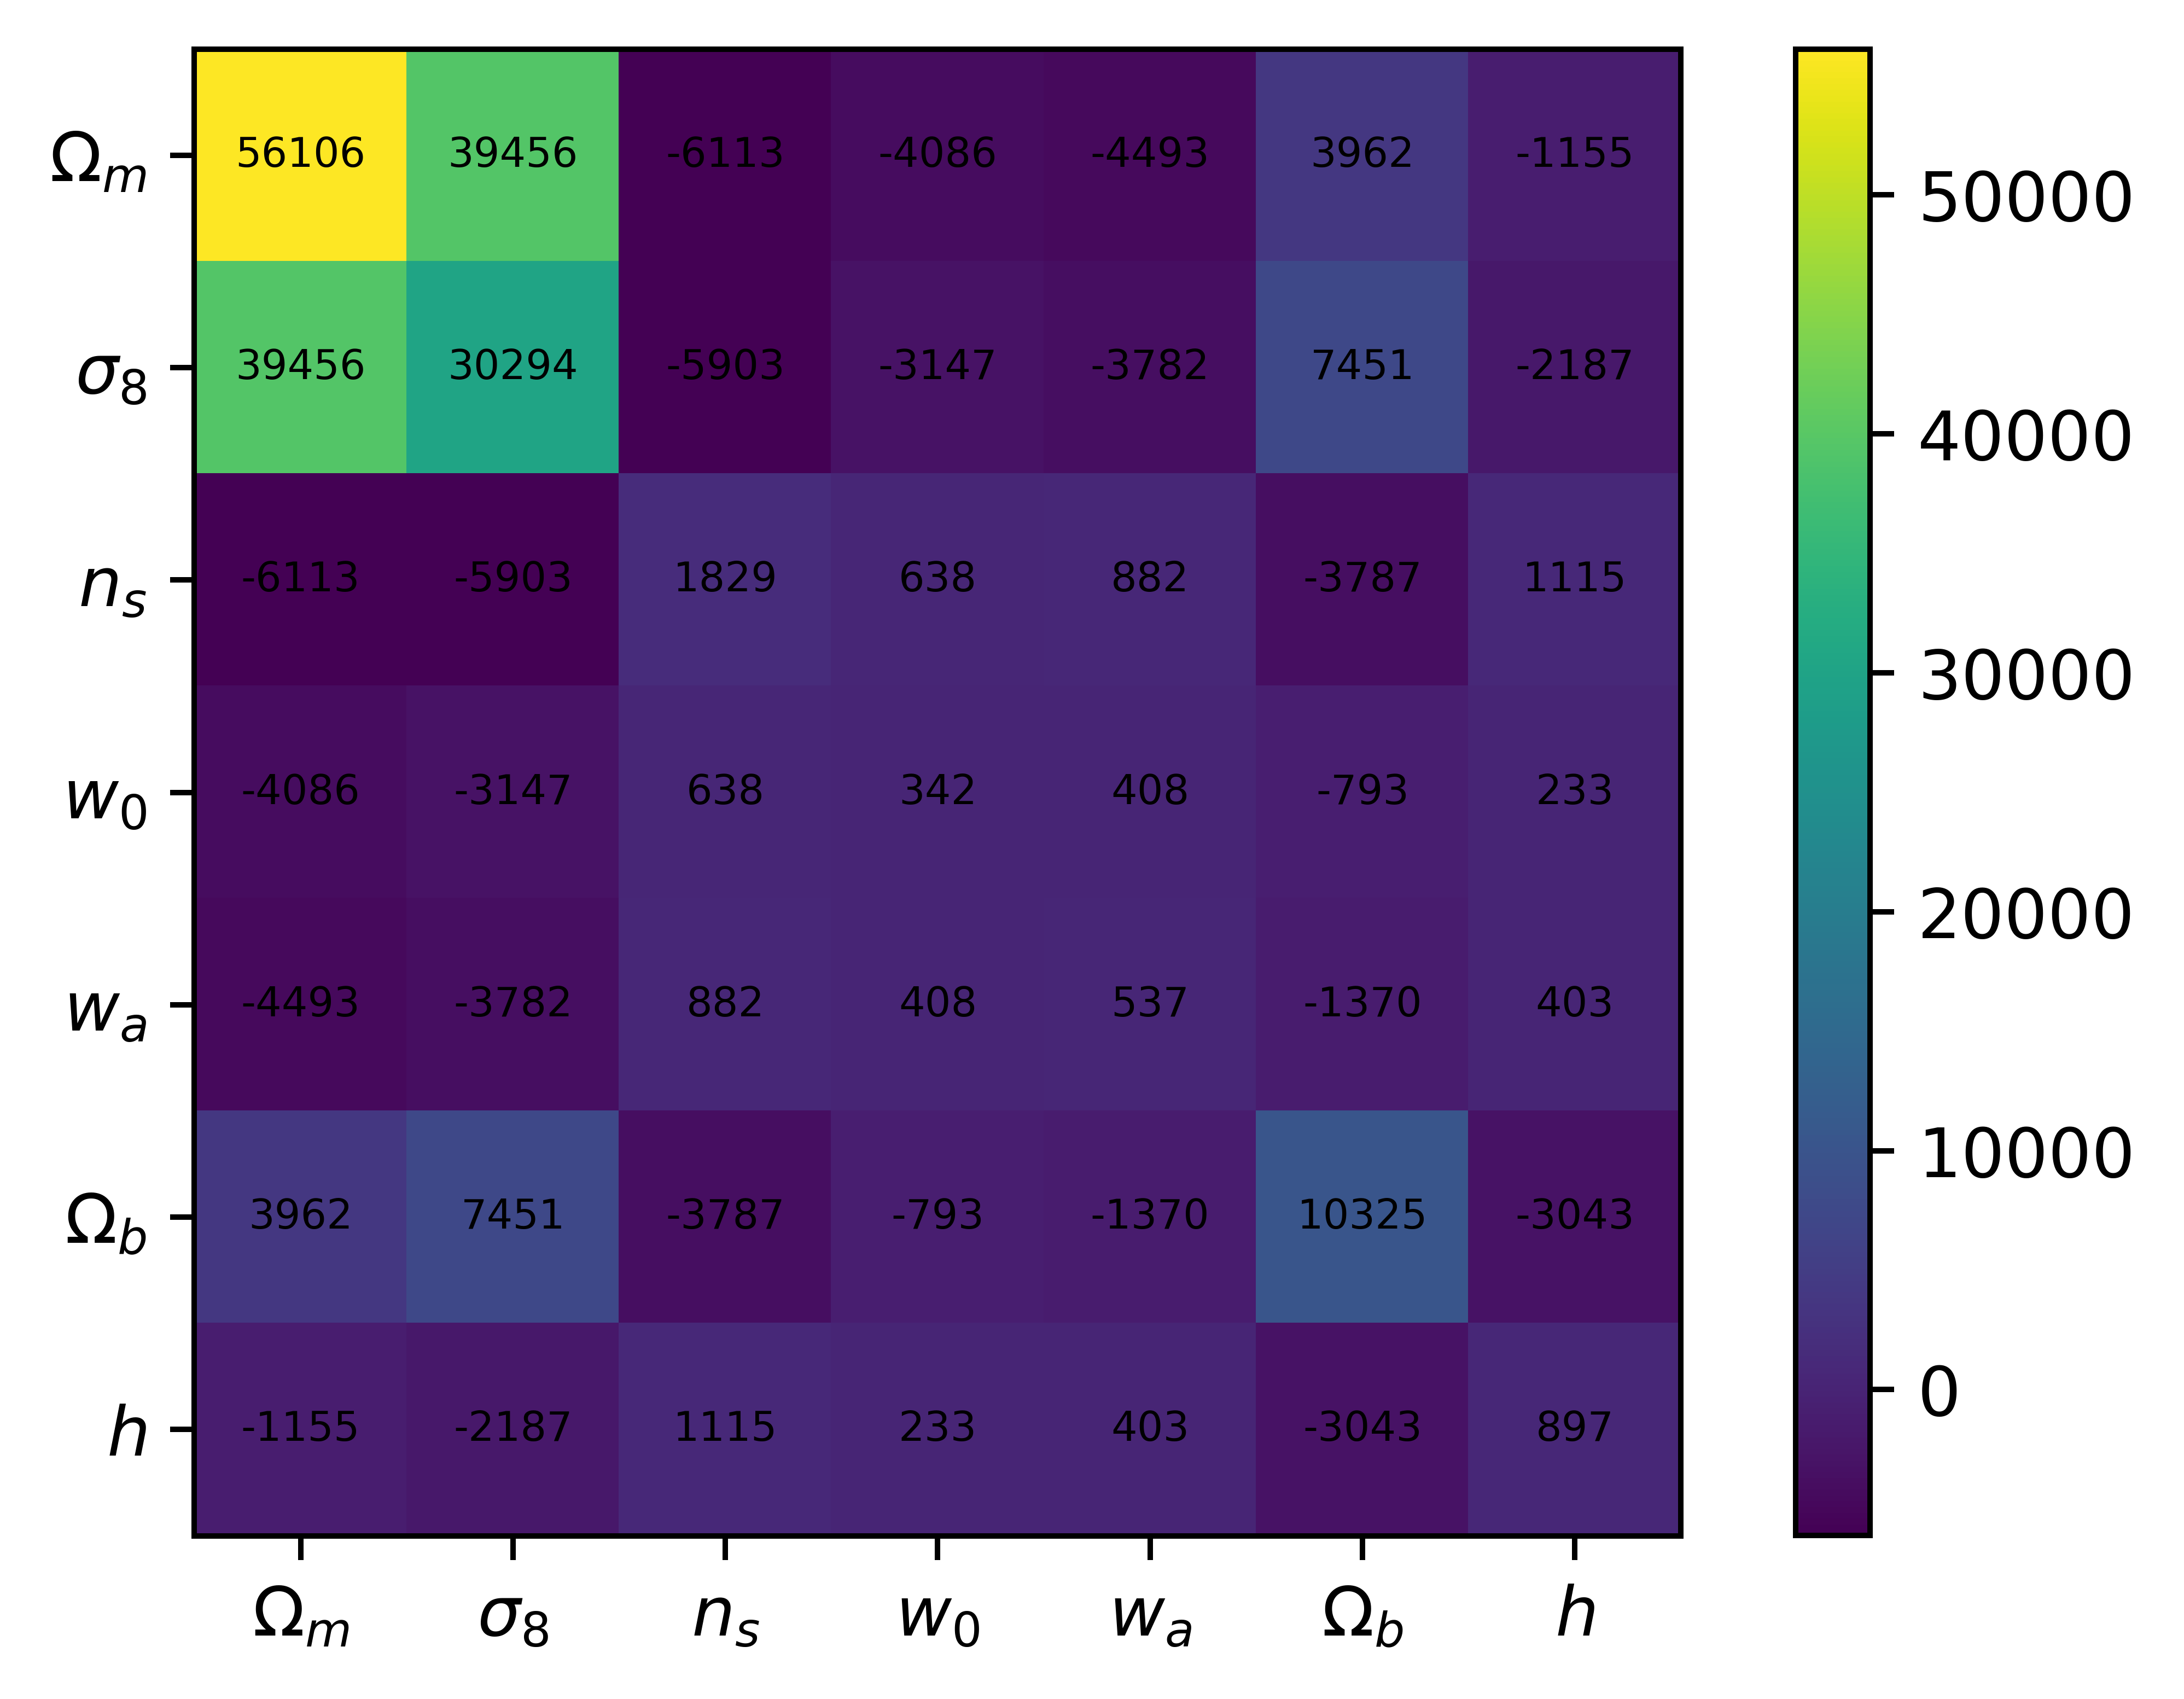

In [25]:
plt.imshow(fisher)
plt.colorbar()
param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$n_s$', r'$w_0$', r'$w_a$', r'$\Omega_b$', r'$h$']
plt.xticks(np.arange(7), param_labels)
plt.yticks(np.arange(7), param_labels)
for i in range(7):
    for j in range(7):
        c = fisher[j,i]
        plt.text(i, j, "%.0f"%(c), va='center', ha='center', fontsize=6)

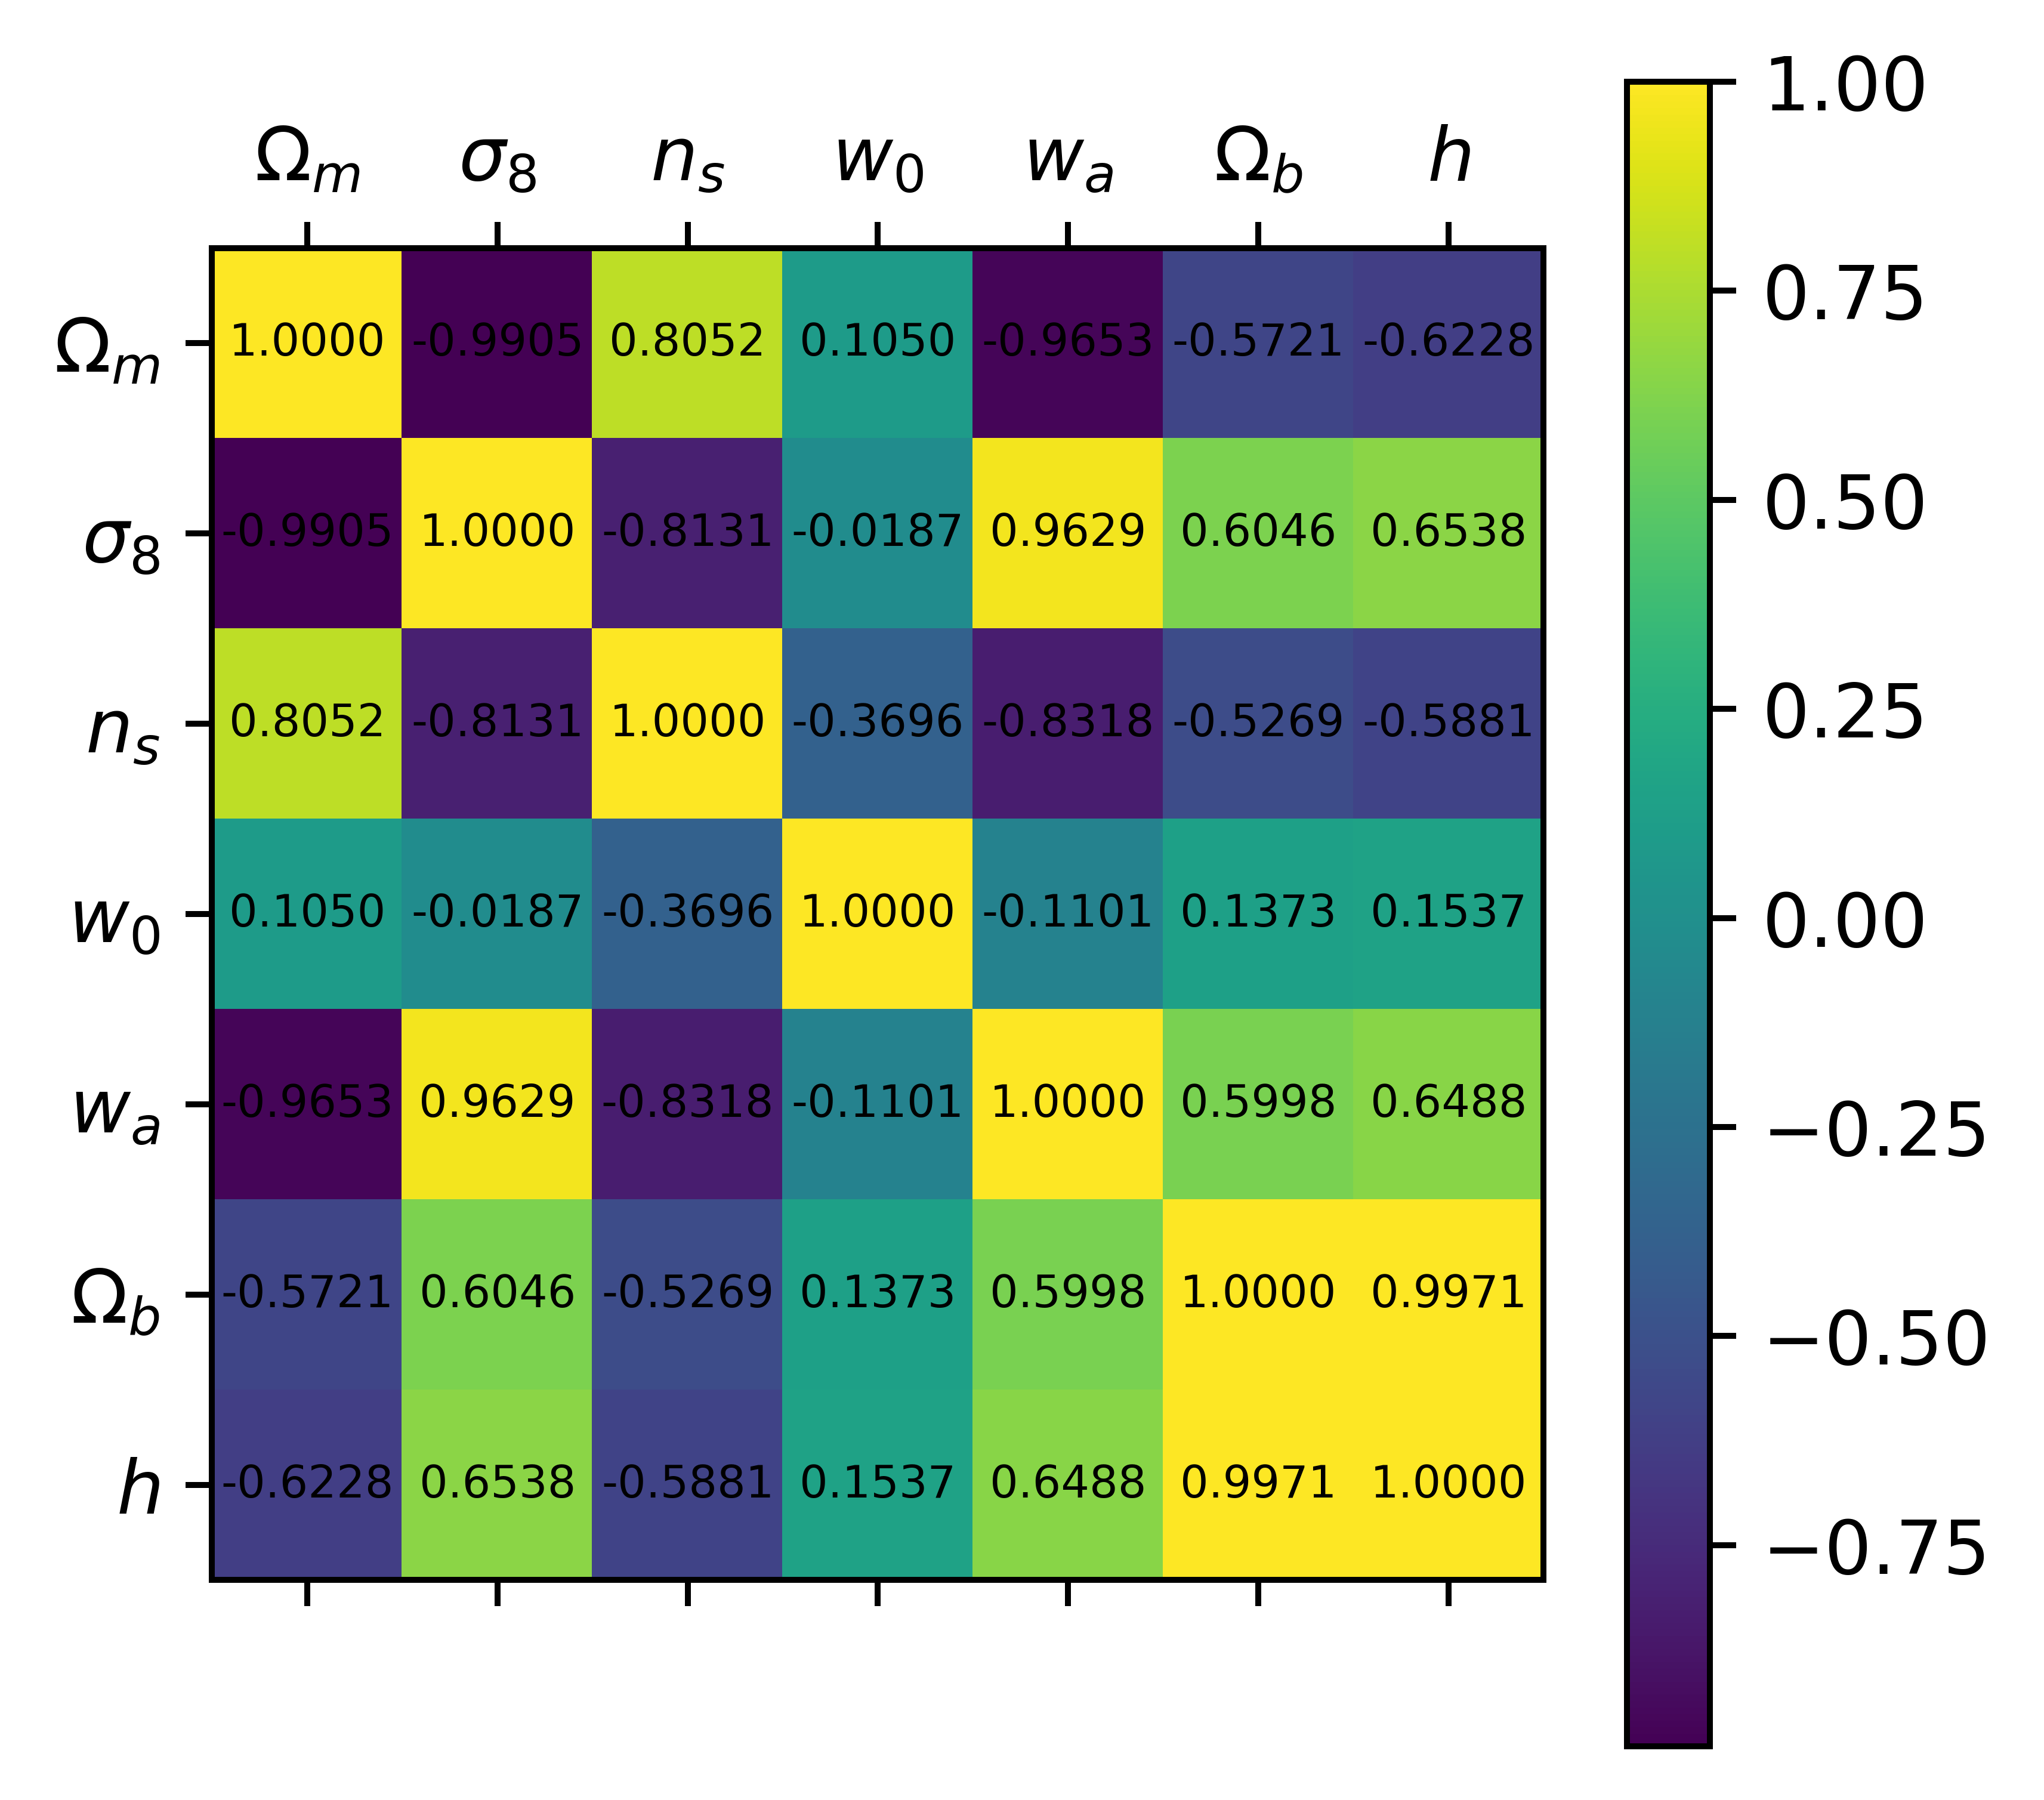

In [26]:
covar_p = cov_cosmo_para(fisher)
cor_p = corr_cosmo_para(covar_p)

plot_corr(cor_p)

w_0 = -1 +- 0.78735839417813

w_a = 0 +- 0.5082087099263658

Figure of Merit for w_0 and w_a is 0.6247775889327273



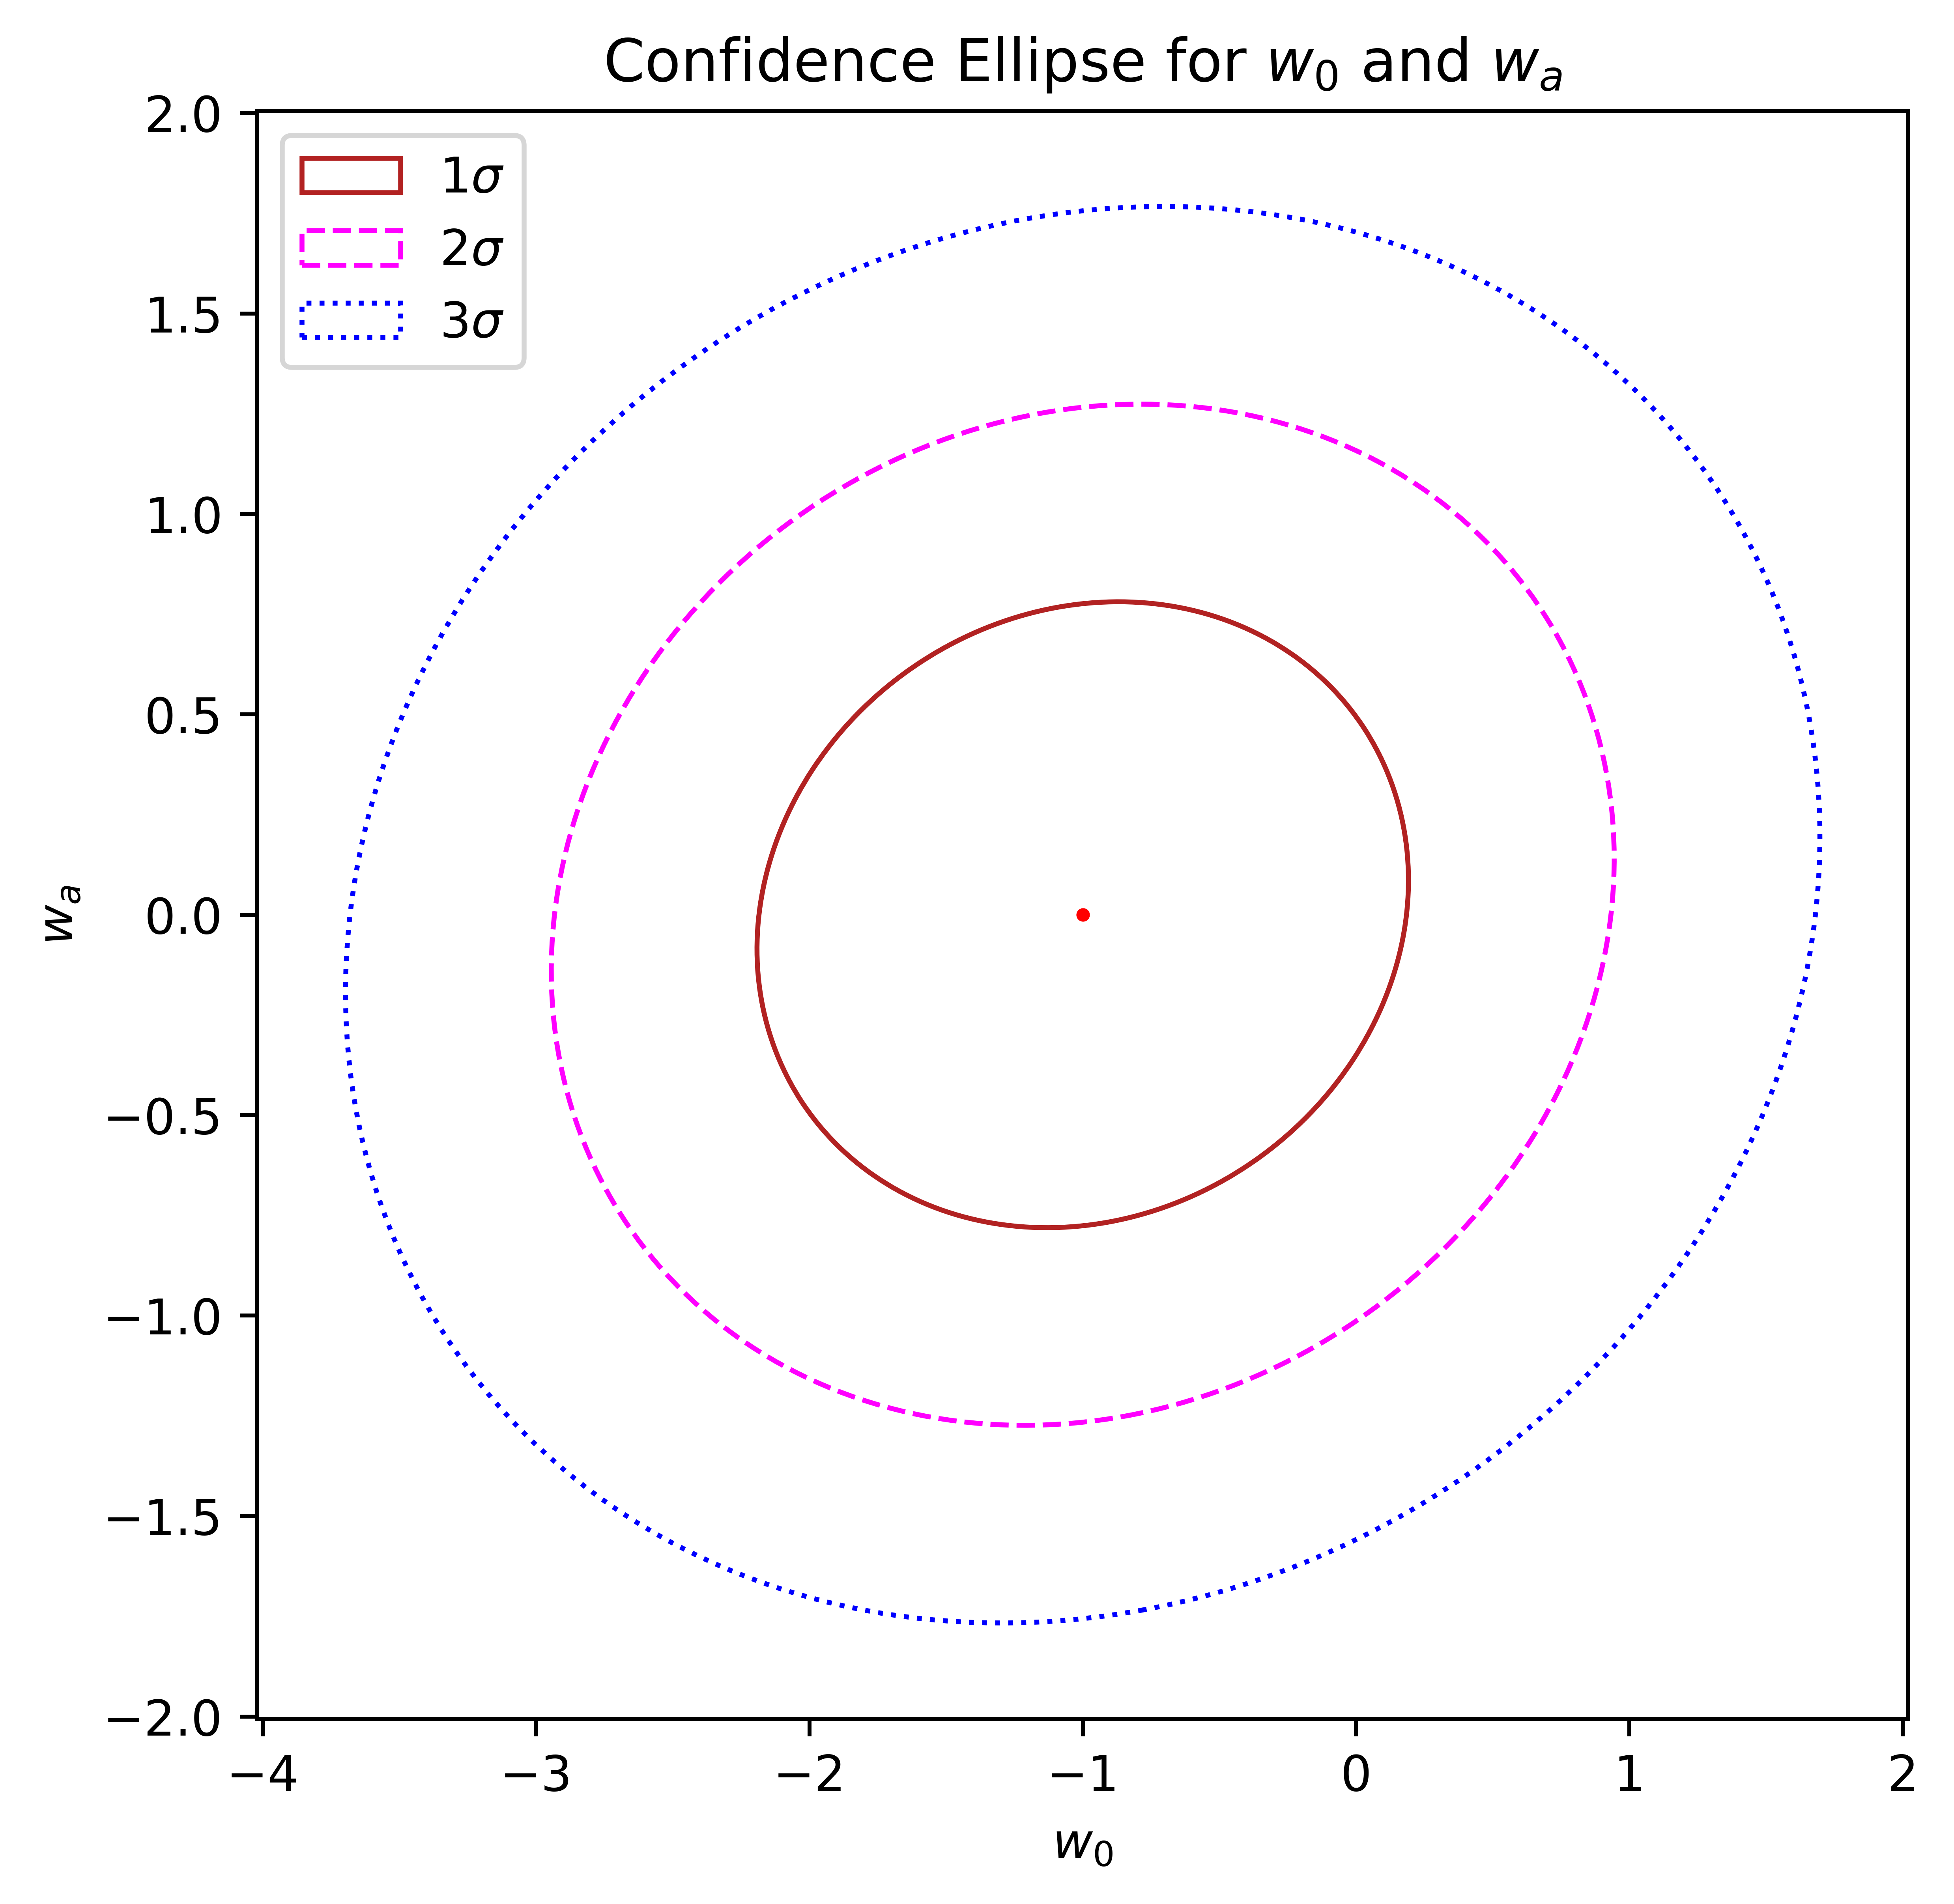

0.6247775889327273

In [27]:
plotConfidenceEllipse(covar_p, "w_0", "w_a")